# Hello 3I/Atlas!

This notebook is a modified version of the "Catch that asteroid" notebook in the poliastro docs. I have modified it to verify dependencies and basic imports of ephemeris data for 3I/Atlas. I also expanded it to analyze closest approach to the sun. I've found this useful for getting familar with the poliastro docs.

NOTE: I don't have any prior experience in orbital mechanics or astrodynamics -- just an engineer interested in 3I/ATLAS.

Happy to receive feedback if you see ways this work can be improved. jason@statespace.info

In [54]:
from astropy.utils.data import conf

conf.dataurl

'http://data.astropy.org/'

First, we need to increase the timeout time to allow the download of data occur properly:

In [26]:
conf.remote_timeout

10.0

In [27]:
conf.remote_timeout = 10000

Then, we do the rest of the imports:

In [48]:
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl") # this line is important --- it is telling the program to pull the ephemeris data from the JPL Horizons data...much more accurate than the built in approximations

from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range

EPOCH = Time("2025-12-19 00:00", scale="tdb") #closest to Earth
C_ATLAS = "#000"
C_MOON = "#999"

([<matplotlib.lines.Line2D at 0x7a17bc1608e0>],
 <matplotlib.lines.Line2D at 0x7a17bc1630a0>)

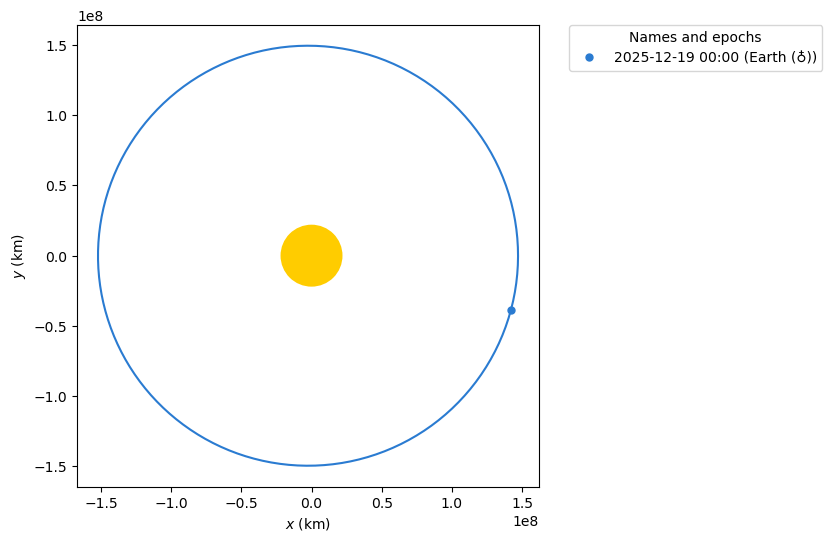

In [38]:
Earth.plot(EPOCH)

The first option to retrieve the orbit of the Atlas-3I comet is to use `Orbit.from_sbdb`, which gives us a snapshot of the orbit at a certain epoch:

In [49]:
atlas_osc = Orbit.from_sbdb("C/2025 N1") # this is the official name for 3I-Atlas in the datasets
atlas_osc

201847044 x -281279074 km x 175.1 deg (HeliocentricEclipticIAU76) orbit around Sun (☉) at epoch 2460859.5008007414 (TDB)

But if this gives a snapshot of the orbit of Atlas-3I, how do I know what time this snapshot is valid for? -- Run the function below:

In [55]:
atlas_osc.epoch.iso

'2025-07-03 00:01:09.184'

Cool. But this is not the time of the closest approach to earth we want to analyze. We need to see into the future.

But if we `propagate` this orbit to `EPOCH`, the results will drift from reality. This is because even really good off-the-shelf orbital mechanics software can still struggle to model all of the forces accurately, especially if it is based on a single snapshot. For example, if for simplicity we assume a two body system, it will not account for the gravitational effects of the planets. And even if you do there are still other factors like relativistic effects and solar radiation pressure. The big kicker, of course, is that with a comet like 3I/Atlas there will also be outgassing. All the more important for us to use some sort of real-world precision trajectory modeling.

Luckily we have JPL. They maintain the JPL Horizons on-line solar system tracker which keeps an updated ephemeride model for even small bodies like asteroids and comets. And they have an API that integrates directly with poliastro!

To access this, we use the `Ephem.from_horizons` method, sampling over a period of 6 months:

In [67]:
epochs = time_range(
    EPOCH - TimeDelta(3 * 30 * u.day), end=EPOCH + TimeDelta(3 * 30 * u.day)
)

In [68]:
atlas = Ephem.from_horizons(
    "C/2025 N1",           # <- use the comet designation
    epochs,
    plane=Planes.EARTH_ECLIPTIC,
    id_type="designation"  # <- tell Horizons what kind of string this is
)

In [69]:
atlas.plane

<Planes.EARTH_ECLIPTIC: 'Earth mean Ecliptic and Equinox of epoch (J2000.0)'>

And now, let's compute the distance between 3I/Atlas and the Earth at that epoch:

In [70]:
earth = Ephem.from_body(Earth, epochs, plane=Planes.EARTH_ECLIPTIC)
earth

Ephemerides at 50 epochs from 2025-09-20 00:00:00.000 (TDB) to 2026-03-19 00:00:00.000 (TDB)

In [81]:
min_distance_earth = norm(atlas.rv(EPOCH)[0] - earth.rv(EPOCH)[0]) - Earth.R
min_distance_earth.to(u.km)

<Quantity 2.74439162e+08 km>

<div class="alert alert-success">That's close to NASA's initial estimate! $270\,000\,000$ km</div>

In [72]:
abs((min_distance - 270000000 * u.km) / (270000000 * u.km)).decompose()

<Quantity 0.01644134>

And now we can plot!

([<matplotlib.lines.Line2D at 0x7a175ecda2c0>],
 <matplotlib.lines.Line2D at 0x7a175ecd9360>)

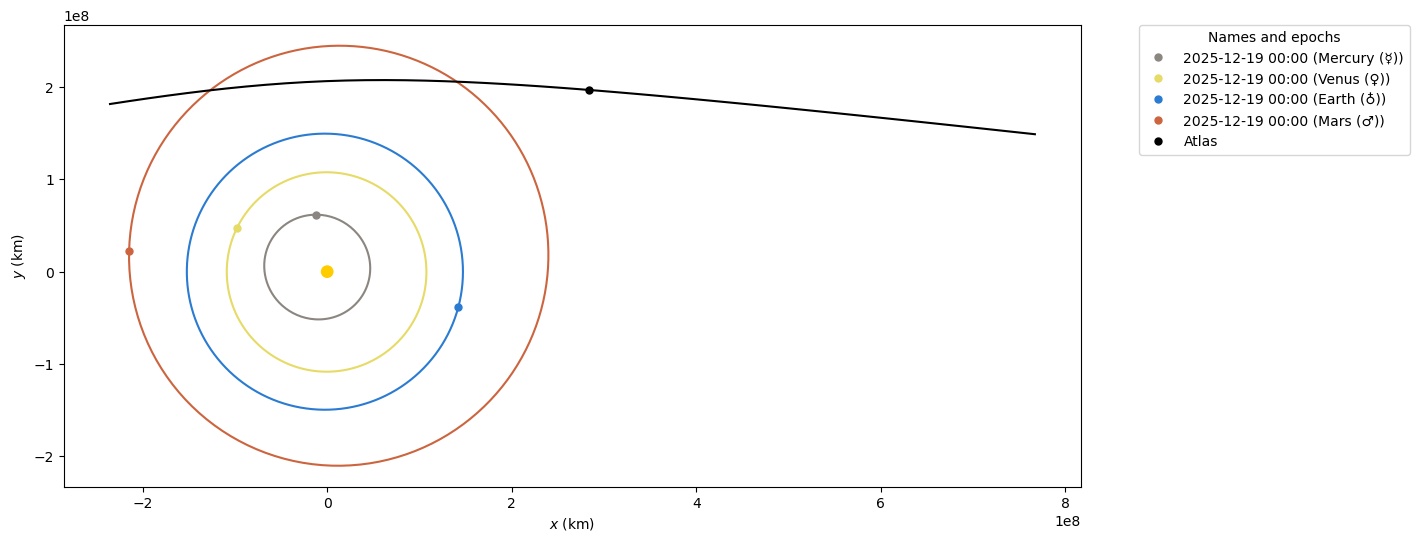

In [74]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot_ephem(atlas, EPOCH, label="Atlas", color=C_ATLAS)

Woah, hyperbolic orbits are pretty cool

Finally, we are going to visualize the orbit of 3I/Atlas with respect to Jupiter's moon Europa next year. For that, we set a narrower time range, and specify that we want to retrieve the ephemerides with respect to Jupiter:

In [110]:
EPOCH2 = Time("2026-03-16 00:00", scale="tdb") #closest to Jupiter second time

epochs = time_range(
    EPOCH2 - TimeDelta(5 * u.day), end=EPOCH2 + TimeDelta(5 * u.day)
)

In [119]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from poliastro.ephem import Ephem
from poliastro.bodies import Jupiter
from poliastro.frames import Planes

EPOCH = Time("2025-07-03", scale="tdb")
epochs = EPOCH + np.arange(-3, 4) * u.day

atlas = Ephem.from_horizons("C/2025 N1", epochs, attractor=Jupiter, plane=Planes.EARTH_ECLIPTIC)
europa = Ephem.from_horizons("502", epochs, attractor=Jupiter, plane=Planes.EARTH_ECLIPTIC)

# Compute relative position at central epoch
r_atlas, _ = atlas.rv(EPOCH)
r_europa, _ = europa.rv(EPOCH)
relative_position = r_atlas - r_europa

print("Relative position (ATLAS - Europa):", relative_position.to(u.km))



Relative position (ATLAS - Europa): [ 8.76357725e+07 -1.42993164e+09  4.48204290e+07] km
